In [4]:
import tensorflow as tf

2025-03-06 06:54:18.019471: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 06:54:18.307175: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 06:54:18.443297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741244058.659076    1786 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741244058.730436    1786 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 06:54:19.725038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [9]:
from keras import layers
from keras import Sequential
from sklearn.model_selection import train_test_split

In [7]:
directory = '/workspaces/CNN-BRAIN-TUMOR/tumor-data'

In [2]:
class_names = ['yes','no']


importing dataset with two classes yes and no using keras utils module

In [8]:
dataset = tf.keras.utils.image_dataset_from_directory( directory,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=None,
    image_size=(256, 256),
    shuffle=True,
    seed=42
)

Found 253 files belonging to 2 classes.


2025-03-06 06:55:19.358107: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


data preprocessing 

splitting data


In [11]:
def splits(dataset,Train_ratio,Val_ratio,Test_ratio):
    
    data_size = len(dataset)
    
    train_dataset = dataset.take(int(data_size*Train_ratio))
    
    val_split_set = dataset.skip(int(data_size*Train_ratio))
    
    val_dataset = val_split_set.take((int(data_size*Val_ratio)))
    
    test_dataset = val_split_set.skip(int(data_size*Test_ratio))
    return train_dataset,val_dataset,test_dataset 

Train_ratio = 0.80 
Val_ratio = .10
Test_ratio = 0.10
train_dataset,val_dataset,test_dataset  = splits(dataset,Train_ratio,Val_ratio,Test_ratio)

print("The length of the train_dataset is  : ",len(train_dataset))
print('The length of the val_dataset is  : ',len(val_dataset))
print('The length of the test_dataset is  : ',len(test_dataset))
      

The length of the train_dataset is  :  202
The length of the val_dataset is  :  25
The length of the test_dataset is  :  26


2025-03-06 07:06:22.300941: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


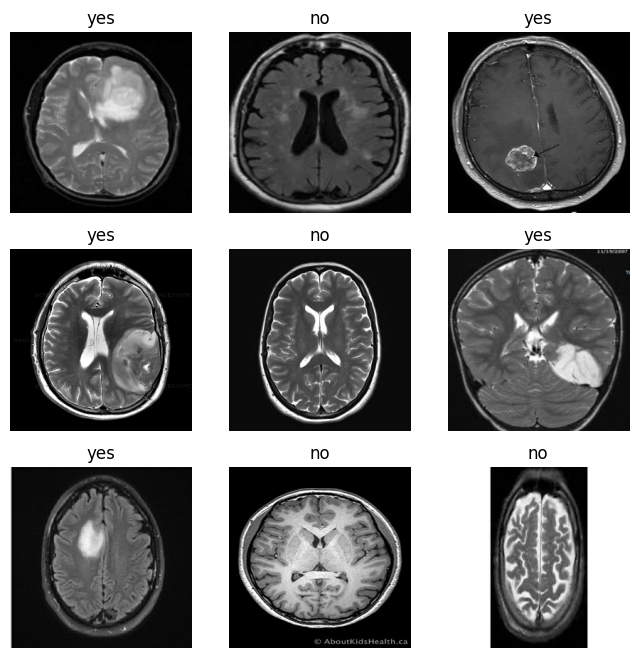

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i,(image,label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image/255)
    plt.title(class_names[label])
    plt.axis('off')

resizing and normalizing

In [14]:
def resize_rescaling(image,label):
    
    return tf.image.resize(image,(224,224))/255,label

In [15]:
train_dataset = (
             train_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(10)
            .prefetch(tf.data.AUTOTUNE)
)

In [16]:
val_dataset = (
             val_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(3)
            .prefetch(tf.data.AUTOTUNE)
)

In [17]:
test_dataset = (
             test_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(1)
            .prefetch(tf.data.AUTOTUNE)
)

In [19]:
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,Flatten,InputLayer,Input
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications import ResNet152V2,DenseNet121,InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy,TruePositives,TrueNegatives,FalseNegatives,FalsePositives
from tensorflow.keras.regularizers import L2
Lenet_model = tf.keras.Sequential([
    InputLayer(shape=(224,224,3)),
    
    Conv2D(filters=32, kernel_size=3,strides=2,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(pool_size=3,strides=2),

    Conv2D(filters=32,kernel_size=3,strides=2,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),
    
    BatchNormalization(),
    MaxPooling2D(pool_size=3,strides=1),
    
    Conv2D(filters=32,kernel_size=3,strides=2,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),
    
    BatchNormalization(),

    MaxPooling2D(pool_size=3,strides=1),
    Dropout(0.2),
    

    Flatten(),
    
    Dense(64,activation='relu'),
    BatchNormalization(),
    
    Dense(64,activation='relu'),
    BatchNormalization(),
    
    Dense(1,activation='sigmoid')
],name='Lenet_model')
Lenet_model.summary()

Model: "Lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,377 (896.00 KB)

 Trainable params: 228,929 (894.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
Lenet_model.compile(loss = BinaryCrossentropy(),
                   optimizer=Adam(learning_rate=0.001),
                   metrics = ['accuracy'])